## A Quick Guide to fine tuning transfer learning 
To begin, we will investigate the different layers of a keras model. 
<br> Let's start with the [Xception architecture](http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf) trained on [Imagenet images and classes](https://en.wikipedia.org/wiki/ImageNet).  
Updated to Tensorflow 2.0

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop

In [2]:
# Initialize a pretrained model with the Xception architecture and weights pretrained on imagenet
input_size = (299,299,3)
model = Xception(weights='imagenet',
                          include_top=True,
                          input_shape=input_size)

W1029 21:03:58.151027 140383853393728 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Here is a function that will show us all of the layers of a model and whether or not they are trainable, with an optional argument to show what 
layer we want to start at

In [3]:
def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print(f"Layer {i+indices} | Name: {layer.name} | Trainable: {layer.trainable}")

In [4]:
print_model_properties(model)

Layer 0 | Name: input_1 | Trainable: True
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization | Trainable: True
Layer 15 | Name: add | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable: True
La

Now let's predict load and predict an image to see what we're working with

In [5]:
def process_img(filename):
    """
    Loads image from filename, preprocesses it and expands the dimensions because the model predict function expects a batch of images, not one image
    """
    original = load_img(filename, target_size = (299,299))
    numpy_image = preprocess_input( img_to_array(original))
    image_batch = np.expand_dims(numpy_image, axis =0)

    return image_batch

In [6]:
!pwd

/tf/Documents/g/dsi/transfer-learning


In [7]:
img_path = 'data/train_small/creme_brulee/1008540.jpg'
process_img(img_path).shape

(1, 299, 299, 3)

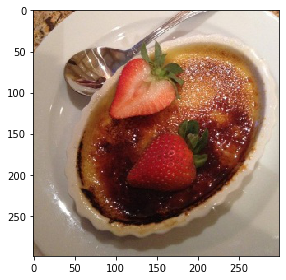

In [9]:
im =  process_img(img_path)
preds =  model.predict(im) # predicting image based on existing
                           # classes in imagenet
from skimage import io
import matplotlib.pyplot as plt
io.imshow(img_path) 

In [10]:
#Imagenet has 1000 different classes
preds.shape

(1, 1000)

In [11]:
# top 5 classes predicted by Xception architecure trained
# on imagenet classes and images
preds = preds.flatten()
print("Sum of output:", preds.sum().round(4))
print("Top 5 Probabilities", np.sort(preds)[::-1][:5])
top_5_indices = preds.argsort()[::-1][:5]
print("Top 5 Indices", top_5_indices)

Sum of output: 1.0
Top 5 Probabilities [0.353721   0.2609343  0.11003338 0.0295682  0.02449004]
Top 5 Indices [923 925 949 928 964]


In [12]:
class_names  = pd.read_json('imagenet_class_index.json', orient='index')
class_names.iloc[top_5_indices]

,0,1
93,n01829413,hornbill
931,n07693725,bagel
953,n07753275,pineapple
934,n07697537,hotdog
967,n07920052,espresso


### Imagenet wasn't trained on creme brulee!

## Transfer learning  
Use ImageNet weights and Xception architecture, and add our own layers to learn the 10 food classes in the data folder.  

### 1. Remove head 

In [13]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

In [14]:
model = create_transfer_model((299,299,3),10)  # only 10 classes in out food data in train folder

In [15]:
print_model_properties(model)

Layer 0 | Name: input_2 | Trainable: True
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d_4 | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization_4 | Trainable: True
Layer 15 | Name: add_12 | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable: 

### 2. Set only new head to trainable

In [16]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [17]:
_ = change_trainable_layers(model, 132)

In [18]:
print_model_properties(model, 130)

Layer 130 | Name: block14_sepconv2_bn | Trainable: False
Layer 131 | Name: block14_sepconv2_act | Trainable: False
Layer 132 | Name: global_average_pooling2d | Trainable: True
Layer 133 | Name: dense | Trainable: True


In [19]:
# Compile model
model.compile(optimizer=RMSprop(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model for 10-30 epochs on AWS

### 3. Training progresses,  open up more layers to training

In [ ]:
_ = change_trainable_layers(model, 102)
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print_model_properties(model, 100)

## Bonus: Some useful os operations for files in multiple directories

In [20]:
!tree -L 3

.
├── README.md
├── assignment.md
├── data
│   ├── holdout_more
│   │   ├── churros
│   │   └── ice_cream
│   ├── holdout_small
│   │   ├── carrot_cake
│   │   ├── creme_brulee
│   │   ├── panna_cotta
│   │   ├── red_velvet_cake
│   │   └── strawberry_shortcake
│   ├── train_more
│   │   ├── churros
│   │   └── ice_cream
│   ├── train_small
│   │   ├── carrot_cake
│   │   ├── creme_brulee
│   │   ├── panna_cotta
│   │   ├── red_velvet_cake
│   │   └── strawberry_shortcake
│   ├── validation_more
│   │   ├── churros
│   │   └── ice_cream
│   └── validation_small
│       ├── carrot_cake
│       ├── creme_brulee
│       ├── panna_cotta
│       ├── red_velvet_cake
│       └── strawberry_shortcake
├── imagenet_class_index.json
├── src
│   ├── simple_cnn.py
│   └── split_training.py
└── transfer_learning.ipynb

29 directories, 6 files


In [21]:
import os
from glob import glob

In [22]:
paths  = glob('data/holdout_small/*')
paths

['data/holdout_small/carrot_cake',
 'data/holdout_small/strawberry_shortcake',
 'data/holdout_small/creme_brulee',
 'data/holdout_small/red_velvet_cake',
 'data/holdout_small/panna_cotta']

In [23]:
os.path.basename(paths[2])

'creme_brulee'

In [24]:
for root, dirs, files in os.walk('data'):
    print(f" root: {root}\n dirs:{dirs}\n files{files}\n\n")

 root: data
 dirs:['holdout_small', 'validation_more', 'train_small', 'train_more', 'validation_small', 'holdout_more']
 files[]


 root: data/holdout_small
 dirs:['carrot_cake', 'strawberry_shortcake', 'creme_brulee', 'red_velvet_cake', 'panna_cotta']
 files[]


 root: data/holdout_small/carrot_cake
 dirs:[]
 files['1978789.jpg', '1551914.jpg', '2142811.jpg', '1389512.jpg', '864516.jpg', '1743264.jpg', '1749092.jpg', '1946721.jpg', '1156181.jpg', '3453489.jpg', '422317.jpg', '1069797.jpg', '3348258.jpg', '213404.jpg', '2942624.jpg', '95302.jpg', '94371.jpg', '1743623.jpg', '2785560.jpg', '455973.jpg', '3016383.jpg', '1364523.jpg', '3441243.jpg', '1200549.jpg', '1151571.jpg', '2505792.jpg', '679549.jpg', '280214.jpg', '1937129.jpg', '332664.jpg', '991592.jpg']


 root: data/holdout_small/strawberry_shortcake
 dirs:[]
 files['1227358.jpg', '3042994.jpg', '802119.jpg', '2721597.jpg', '495796.jpg', '2442414.jpg', '2368487.jpg', '976997.jpg', '2424174.jpg', '13097.jpg', '2057948.jpg', '217